Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\hitha sunil\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best parameters: {'clf__max_depth': 8, 'clf__min_samples_leaf': 20, 'clf__min_samples_split': 50}
Best CV AUC: 0.7257357350677731

Classification Report:
              precision    recall  f1-score   support

           0     0.9246    0.5083    0.6560     17642
           1     0.3009    0.8362    0.4425      4464

    accuracy                         0.5745     22106
   macro avg     0.6127    0.6723    0.5492     22106
weighted avg     0.7987    0.5745    0.6129     22106

Accuracy: 0.5745
Precision: 0.3009
Recall: 0.8362
F1-Score: 0.4425
ROC AUC: 0.7246


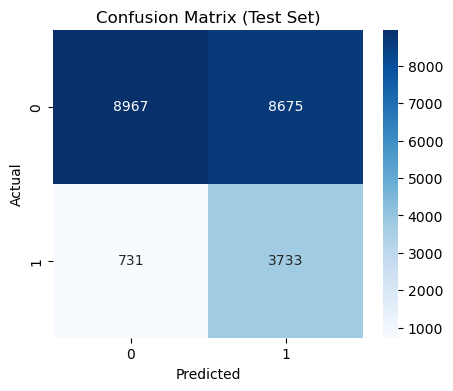

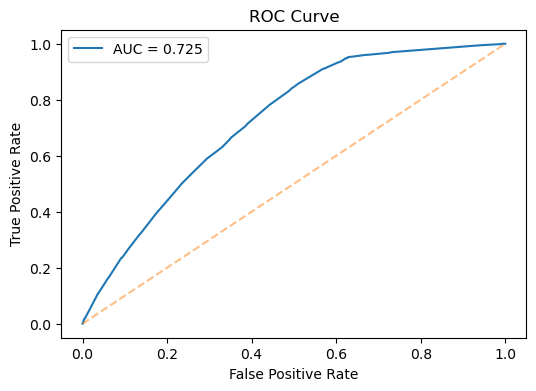

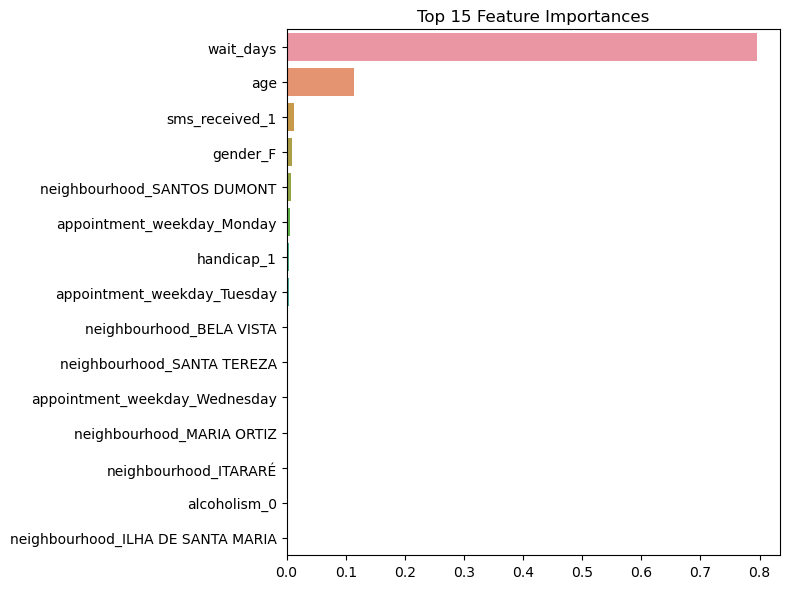


--- Optimization Recommendations ---
- Use SMS reminders: 'sms_received' often reduces no-show rates.
- Reduce 'wait_days': shorter wait times correlate with fewer no-shows.
- Pay attention to weekdays: no-shows may be higher on Mondays or Fridays.
- Older patients or those with chronic conditions may have lower no-show risk.
- Prioritize reminder calls for high-risk groups (predicted probability > 0.6).


In [1]:
# healthcare_no_show_prediction_clean.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# ---------- 1. Load data ----------
DATA_PATH = "C:/Users/hitha sunil/Documents/Data Set/medical_appointments.csv" # <-- Replace with your file path
df = pd.read_csv(DATA_PATH)

# ---------- 2. Clean column names ----------
df.columns = df.columns.str.strip().str.lower()
# Rename columns for consistent reference
df.rename(columns={
    'hipertension': 'hypertension',
    'handcap': 'handicap',
    'no-show': 'no_show'
}, inplace=True)

# ---------- 3. Convert and clean ----------
df['scheduledday'] = pd.to_datetime(df['scheduledday'], errors='coerce')
df['appointmentday'] = pd.to_datetime(df['appointmentday'], errors='coerce')
df = df.dropna(subset=['scheduledday', 'appointmentday', 'age', 'no_show'])

# Convert No-show to binary (Yes=1, No=0)
df['no_show'] = df['no_show'].str.strip().str.lower().map({'yes': 1, 'no': 0})

# Remove invalid ages
df = df[(df['age'] >= 0) & (df['age'] < 120)]

# ---------- 4. Feature engineering ----------
df['wait_days'] = (df['appointmentday'].dt.date - df['scheduledday'].dt.date).apply(lambda x: x.days)
df.loc[df['wait_days'] < 0, 'wait_days'] = 0

df['appointment_weekday'] = df['appointmentday'].dt.day_name()
df['is_weekend'] = df['appointmentday'].dt.weekday >= 5

# ---------- 5. Define features and target ----------
features = [
    'age', 'gender', 'neighbourhood', 'scholarship', 'hypertension', 'diabetes',
    'alcoholism', 'handicap', 'sms_received', 'wait_days', 'appointment_weekday', 'is_weekend'
]
X = df[features]
y = df['no_show']

# ---------- 6. Preprocessing ----------
numeric_features = ['age', 'wait_days']
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ---------- 7. Split data ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------- 8. Model and grid search ----------
clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', clf)])

param_grid = {
    'clf__max_depth': [3, 5, 8, 12],
    'clf__min_samples_split': [2, 10, 50],
    'clf__min_samples_leaf': [1, 5, 20]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

# ---------- 9. Evaluation ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# ---------- 10. Confusion matrix ----------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ---------- 11. ROC curve ----------
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], '--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ---------- 12. Feature importance ----------
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
ohe_features = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + ohe_features
importances = best_model.named_steps['clf'].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index)
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# ---------- 13. Practical scheduling recommendations ----------
print("\n--- Optimization Recommendations ---")
print("- Use SMS reminders: 'sms_received' often reduces no-show rates.")
print("- Reduce 'wait_days': shorter wait times correlate with fewer no-shows.")
print("- Pay attention to weekdays: no-shows may be higher on Mondays or Fridays.")
print("- Older patients or those with chronic conditions may have lower no-show risk.")
print("- Prioritize reminder calls for high-risk groups (predicted probability > 0.6).")
